# Homework: NN vs LeNet vs MyOwnCNN

In this notebook, you will find:
1. NN & LeNET code, borrowed from https://github.com/spbcoding/ml-aws-course/blob/torch/lab07-cnn-1%20(pytorch).ipynb
2. The results of my attempt to create the CNN
3. Comparison of NN from p. 1. and 2.



### Here is borrowed code for NN & LeNet


In [255]:
import torch
from typing import Tuple, Any
from torch import nn
import torch.optim as optim

import pickle

import numpy as np
import matplotlib.pyplot as plt

In [256]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [257]:
# Open the files:
train_fh = open('data/lego/lego-train.pickle', 'rb')
test_fh = open('data/lego/lego-test.pickle', 'rb')

# Use pickle to load files into runtime objects:
train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label) 

In [258]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

img_transforms = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

def get_dataset(X, y):
    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x,tensor_y) # create your dataset
    return dataset

train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)


In [259]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']


Original shape is  torch.Size([48, 48, 1])


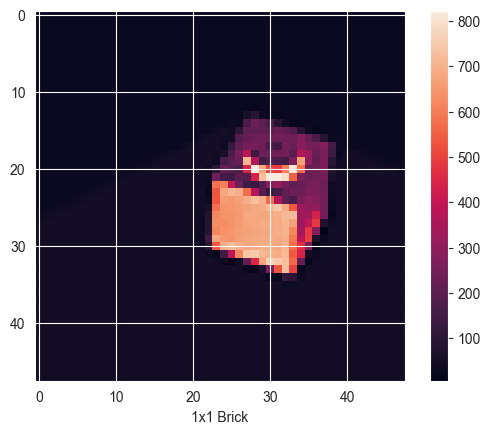

In [260]:
# the same, but with torch dataset
train_dataloader = DataLoader(train_dataset)
images_data, label_data = next(iter(train_dataloader)) 

print('Original shape is ', images_data[0].shape)
plt.figure()
plt.imshow(images_data[0].numpy())
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

In [261]:
# Define a neural network as per the original lab
def build_NN():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    net = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(48*48, 128),
        torch.nn.Sigmoid(),
        torch.nn.Linear(128, 64),
        torch.nn.Sigmoid(),
        torch.nn.Linear(64, 10)
    )
    
    net.apply(init_weights)
    
    return net

In [262]:
from tqdm import tqdm
# let's use some fancy visualization of progress - https://github.com/tqdm/tqdm

In [263]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                # batch x [48, 48, 1] -> batch x [1, 48, 48]
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


In [264]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [265]:
net = build_NN()
print(net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=64, out_features=10, bias=True)
)


In [266]:
# prepare training
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 99, Batch: 14, Loss: 20.23, Acc: 1.00: 100%|██████████| 1500/1500 [00:09<00:00, 155.77it/s]


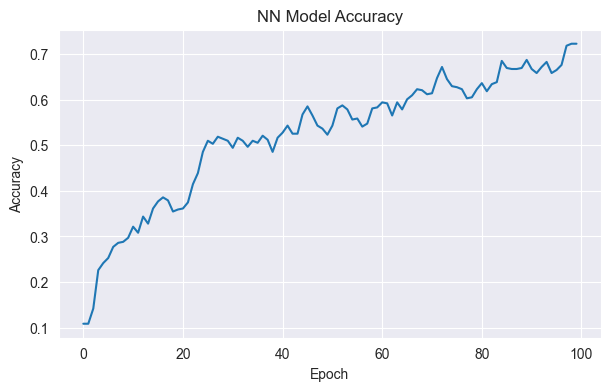

In [267]:
print_history(hist, "NN Model Accuracy")

In [268]:

def build_lenet():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
        
    net = torch.nn.Sequential(
        # Input: 48x48
    
        torch.nn.Conv2d(1, 6, 5, padding=(2,2)), # out: 48x48x6
        torch.nn.ReLU(),
        
        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 24x24x6
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(6, 16, 5), # out: 20x20x16
        torch.nn.ReLU(),

        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 10x10x16

        torch.nn.Flatten(),
        
        torch.nn.Linear(10*10*16, 120),
        torch.nn.Sigmoid(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )
  
    net.apply(init_weights)
    return net


In [269]:
lenet = build_lenet()
print(lenet) 

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): ReLU()
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1600, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)


In [270]:
hist_lenet = train(lenet, train_dataloader, device, EPOCHS, LR)

Epoch: 99, Batch: 14, Loss: 12.64, Acc: 1.00: 100%|██████████| 1500/1500 [00:25<00:00, 59.56it/s]


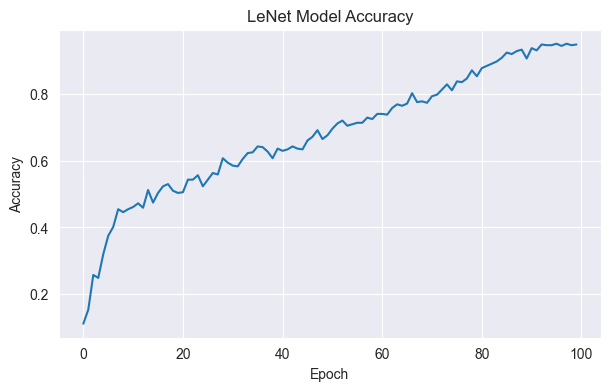

In [271]:
print_history(hist_lenet, "LeNet Model Accuracy")

## My own CNN (MOCNN)
(Actually, creating CNN was the point of the ht)

#### Attempt to build smaller net compared to LeNet (1 conv layer vs 2)

In [272]:
# It is kinda based on the LeNet code shown earlier
def build_MOCNN_S():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
        
    mocnn = torch.nn.Sequential(
        # Input: 48x48
    
        torch.nn.Conv2d(1, 16, 5, padding=(2,2)), # out: 48x48x16
        torch.nn.ReLU(),
        
        torch.nn.AvgPool2d(kernel_size=(6,6), stride=(6,6)), # out: 16x16x16
        
        

        torch.nn.Flatten(),
        
        torch.nn.Linear(8*8*16, 120),
        torch.nn.Sigmoid(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )
  
    mocnn.apply(init_weights)
    return mocnn


In [273]:
my_cnn_s = build_MOCNN_S()
print(my_cnn_s)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(6, 6), stride=(6, 6), padding=0)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=1024, out_features=120, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=120, out_features=84, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=84, out_features=10, bias=True)
)


In [274]:
hist_cnn = train(my_cnn_s, train_dataloader, device, EPOCHS, LR)

Epoch: 99, Batch: 14, Loss: 11.15, Acc: 1.00: 100%|██████████| 1500/1500 [00:22<00:00, 65.22it/s]


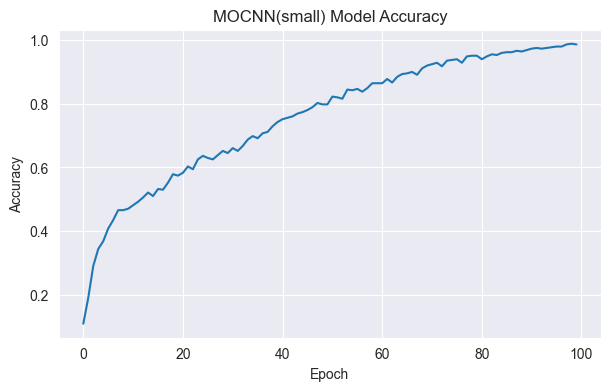

In [275]:
print_history(hist_cnn, "MOCNN(small) Model Accuracy")

### Attempt to build bigger net compared to LeNet (5 conv layer vs 2)

In [276]:
# It is kinda based on the LeNet code shown earlier
def build_MOCNN_B():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)

    mocnn = torch.nn.Sequential(
        # Input: 48x48

        torch.nn.Conv2d(1, 3, 5, padding=(2, 2)),  # out: 48x48x3
        torch.nn.ReLU(),
        
        torch.nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),  # out: 24x24x3
        
        torch.nn.Conv2d(3, 9, 5, padding=(1, 1)),  # out: 24x24x9
        torch.nn.ReLU(),

        torch.nn.AvgPool2d(kernel_size=(2, 2), stride=(1, 1)),  # out: 24x24x9
        
        torch.nn.Conv2d(9, 18, 5, padding=(2, 2)),  # out: 24x24x18
        torch.nn.ReLU(),

        torch.nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),  # out: 12x12x18
        
        torch.nn.Conv2d(18, 40, 3, padding=(1, 1)),  # out: 10x10x40
        torch.nn.ReLU(),

        torch.nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),  # out: 5x5x40


        torch.nn.Flatten(),

        torch.nn.Linear(5 * 5 * 40, 120),
        torch.nn.Sigmoid(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )

    mocnn.apply(init_weights)
    return mocnn

In [277]:
my_cnn_b = build_MOCNN_B()
print(my_cnn_b)

Sequential(
  (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0)
  (6): Conv2d(9, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU()
  (8): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (9): Conv2d(18, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=1000, out_features=120, bias=True)
  (14): Sigmoid()
  (15): Linear(in_features=120, out_features=84, bias=True)
  (16): Sigmoid()
  (17): Linear(in_features=84, out_features=10, bias=True)
)


In [278]:
hist_cnn_b = train(my_cnn_b, train_dataloader, device, EPOCHS, LR)

Epoch: 99, Batch: 14, Loss: 10.03, Acc: 1.00: 100%|██████████| 1500/1500 [00:39<00:00, 37.75it/s]


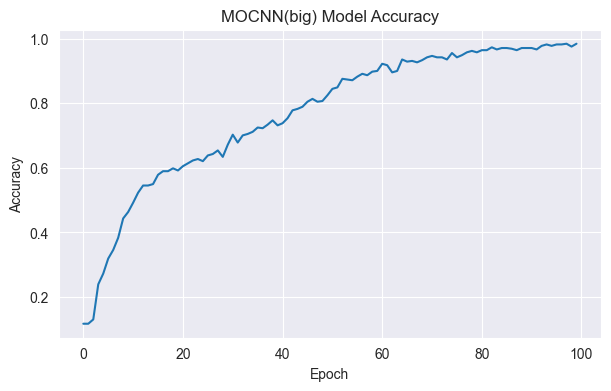

In [279]:
print_history(hist_cnn_b, "MOCNN(big) Model Accuracy")

## Some fancy metrics and graphs

In [280]:
def evaluate_acc(net, test_loader, device):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    return acc


In [281]:
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [282]:
def print_histories(histories: list[tuple[Any, str]], title):
    plt.figure(figsize=(7, 4))
    for dots, legend in histories:
        plt.plot(dots, label=legend)
    plt.title(title)
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

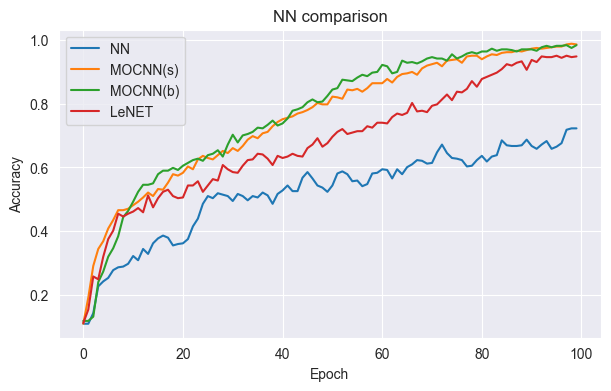

In [283]:
print_histories([(hist, "NN"), (hist_cnn, "MOCNN(s)"), (hist_cnn_b, "MOCNN(b)"), (hist_lenet, "LeNET")], "NN comparison")

In [284]:
net_acc = evaluate_acc(net, test_dataloader, device)
lenet_acc = evaluate_acc(lenet, test_dataloader, device)
mocnns_acc = evaluate_acc(my_cnn_s, test_dataloader, device)
mocnnb_acc = evaluate_acc(my_cnn_b, test_dataloader, device)
print('Test Accuracy (NN): {:.2%}'.format(net_acc))
print('Test Accuracy (LeNet): {:.2%}'.format(lenet_acc))
print('Test Accuracy (MOCNN (small)): {:.2%}'.format(mocnns_acc))
print('Test Accuracy (MOCNN (big)): {:.2%}'.format(mocnnb_acc))

Test Accuracy (NN): 71.33%
Test Accuracy (LeNet): 98.67%
Test Accuracy (MOCNN (small)): 99.33%
Test Accuracy (MOCNN (big)): 96.00%


## Results
1. Regular NN performs awfully bad on tasks of classifying images, compared to CNN
2. Although it took the least amount of time to fully train NN (about half the MOCNN(s) time), CNN has the same accuracy scores with 1/4 of CNN's train time (5s, compared to 11s of fully trained NN). This means, that CNNs are winning over other NN not only by accuracy scores, but by the time as well.    
2. CNN with 1 conv layer [MOCNN(s)] trains 30% faster than LeNET, and usually has better accuracy scores, although showing inconsistent results from launch to launch.
3. CNN with 4 conv layers [MOCNN(b)] trains 18% slower than LeNET, and has about the same accuracy scores after epoch 50 as MOCNN(s). It has to be mentioned, that MOCNN(b) shows more consistent results from train to train than other CNN's.

## Conclusion
#### MOCNN(S) - 1 conv layer cnn - shown best time & accuracy scores, mostly because of small size of images in dataset, categories of images and features.   